logistic regression on mnist using batchflow over pytorch via config layout defenition

In [1]:
import sys
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('../../../batchflow')

from batchflow import B, V, C, Pipeline, Config
from batchflow.models.metrics import ClassificationMetrics
from batchflow.models.torch.layers import Dense
from batchflow.models.torch import TorchModel
from batchflow.opensets import MNIST
from batchflow import best_practice

In [2]:
BATCH_SIZE = 64
mnist = MNIST()

Extracting /var/folders/d0/4xbr3ghj1nz4yr0d97gg0wkc0000gn/T/train-images-idx3-ubyte.gz
Extracting /var/folders/d0/4xbr3ghj1nz4yr0d97gg0wkc0000gn/T/train-labels-idx1-ubyte.gz
Extracting /var/folders/d0/4xbr3ghj1nz4yr0d97gg0wkc0000gn/T/t10k-images-idx3-ubyte.gz
Extracting /var/folders/d0/4xbr3ghj1nz4yr0d97gg0wkc0000gn/T/t10k-labels-idx1-ubyte.gz


In [3]:
model_config_f = {
    'inputs': dict(images={'shape': (1, 28, 28),
                           'data_format': 'channels_first'},
                   labels={'classes': 10}),
    'loss': 'ce',
    'optimizer': 'Adam',
    'initial_block/inputs': 'images',
    'body/units': 10,
    'body/layout': 'f',
    'output': dict(predicted=['proba', 'labels'])
}

model_config_ff = model_config_f + Config({'body/layout' : 'fa f', 'body/units' : [1000,10]})

In [4]:
train_pipeline = (mnist.train.p
    .init_variable('loss_history_f', init_on_each_run=list)
    .init_variable('loss_history_ff', init_on_each_run=list)
    .init_model('dynamic', TorchModel, 'f', model_config_f)
    .init_model('dynaminc', TorchModel, 'ff', model_config_ff)
    .to_array('float32', 'channels_first')
    .train_model('f', B('images'), B('labels'), fetches='loss', save_to=V('loss_history_f'), mode='a')
    .train_model('ff', B('images'), B('labels'), fetches='loss', save_to=V('loss_history_ff'), mode='a')
)

In [5]:
train_pipeline.run(BATCH_SIZE, shuffle=True, n_epochs=1, bar=True);

100%|█████████▉| 937/938 [00:27<00:00, 27.62it/s]


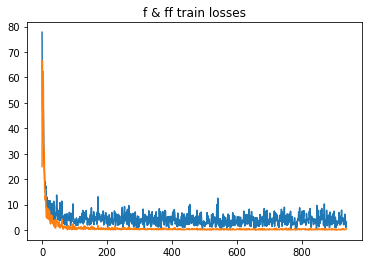

In [6]:
plt.plot(train_pipeline.get_variable('loss_history_f'))
plt.plot(train_pipeline.get_variable('loss_history_ff'))
plt.title('f & ff train losses');

In [7]:
test_pipeline = (mnist.test.p
    .init_variable('predictions_f')
    .init_variable('predictions_ff')
    .init_variable('metrics_f')
    .init_variable('metrics_ff')
    .import_model('f', train_pipeline)
    .import_model('ff', train_pipeline)
    .to_array('float32', 'channels_first')
    .predict_model('f', B('images'), B('labels'),
                   fetches='predicted_proba', save_to=V('predictions_f'), mode='w')
    .predict_model('ff', B('images'), B('labels'),
                   fetches='predicted_proba', save_to=V('predictions_ff'), mode='w')
    .gather_metrics(ClassificationMetrics, targets=B('labels'), predictions=V('predictions_f'),
                                fmt='logits', axis=1, save_to=V('metrics_f'), mode='u')
    .gather_metrics(ClassificationMetrics, targets=B('labels'), predictions=V('predictions_ff'),
                                fmt='logits', axis=1, save_to=V('metrics_ff'), mode='u')
    .run(BATCH_SIZE, n_epochs=1, bar=True)
)

 99%|█████████▉| 156/157 [00:02<00:00, 75.88it/s]


In [8]:
metrics_f = test_pipeline.get_variable('metrics_f')
metrics_ff = test_pipeline.get_variable('metrics_ff')

In [9]:
print('f:\n\n', metrics_f._confusion_matrix, '\n\nfa f\n\n' , metrics_ff._confusion_matrix)

f:

 [[[ 935    0    6    3    2    8    8    0    6    5]
  [   0 1090   28    2    1    1    3    6    4    1]
  [   0    6  871   26    2    0    3   16   10    0]
  [   2   15   27  893    1   58    3    5   26   15]
  [   1    1    8    4  914   20    2    8   21   64]
  [   7    4    5   30    0  735   21    0   31    1]
  [  22    3   23    4   14   10  914    0    9    1]
  [   7    2   28   19   17   18    2  969   25   96]
  [   6   14   31   26    9   38    2    7  839   14]
  [   0    0    5    3   22    4    0   17    3  812]]] 

fa f

 [[[ 961    0    7    0    0    5    5    2    2    2]
  [   0 1120   26    0    1    2    3    4    2    3]
  [   0    2  880    3    4    1    4    6    0    2]
  [   1    1   58  976    0   26    0    7   11   13]
  [   1    1    4    2  959    3    6   11    6  119]
  [   0    1    0    5    1  831    9    0    8    3]
  [   5    3    2    0    5    3  927    0    4    1]
  [   4    3   28    3    4    2    0  993    9   28]
  [   8    4

In [10]:
metrics_f.evaluate('accuracy'), metrics_ff.evaluate('accuracy')

(0.8972, 0.9402)

In [11]:
train_pipeline.save_model('f', path='../models/config layout f')
train_pipeline.save_model('f', path='../models/config layout ff')